In [1]:
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds

In [2]:
%matplotlib inline

In [3]:
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

In [4]:
appliance_index

{'aggregate': 0, 'dw': 4, 'fridge': 2, 'hvac': 1, 'mw': 3, 'oven': 6, 'wm': 5}

In [8]:
region, year='Austin', 2014
df, dfc = create_matrix_single_region(region, year)
start, stop=1, 13
energy_cols = np.array([['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

static_cols = ['area', 'total_occupants', 'num_rooms']
static_df = df[static_cols]
static_df = static_df.div(static_df.max())
weather_values = np.array(dds[2014]['Austin'][start - 1:stop - 1]).reshape(-1, 1)

dfc = df.copy()

df = dfc[energy_cols]
col_max = df.max().max()
col_min = df.min().min()
#df = (1.0 * (df - col_min)) / (col_max - col_min)
tensor = df.values.reshape((len(df), 7, stop-start))
M, N, O = tensor.shape
mask = np.ones(M).astype('bool')

case=2
a=3
b=2
cost='abs'
pred = {}

tensor_copy = tensor.copy()
#tensor_copy[i, 1:, :] = np.NaN
#H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=2000, lr=0.1, dis=True, cost_function=cost, H_known=static_df.values[:, :1],
#                   T_known=weather_values)
H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, H_known=static_df.values[:,:1])
HAT = multiply_case(H, A, T, case)
    
        


In [74]:
from plot_functions import *

In [9]:
H.shape, A.shape, T.shape

((539, 3), (7, 3, 2), (12, 2))

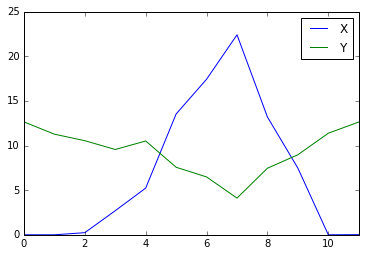

In [29]:
T_fac = pd.DataFrame(T).T
T_fac.index = ['Y', 'X']
T_fac = T_fac.ix[['X','Y']].T
T_fac.plot()

In [108]:
T_fac

,X,Y
0,0.000000,12.645042
1,0.000000,11.270897
2,0.238467,10.539938
3,2.700383,9.555399
4,5.231649,10.508225
5,13.533117,7.565273
6,17.424600,6.481728
7,22.399441,4.111722
8,13.193784,7.457859
9,7.468432,8.966047


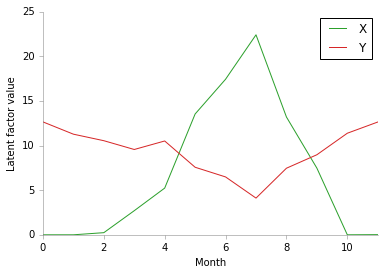

In [147]:
T_fac.plot(colors=tableau20blind[4:][::2])
format_axes(plt.gca())
plt.xlabel("Month")
plt.ylabel("Latent factor value")

In [36]:
A_appl = {appliance:A[i][:,::-1] for i, appliance in enumerate(APPLIANCES_ORDER)}

In [37]:
pd.DataFrame(A_appl['aggregate'])

,0,1
0,5.029992,6.549570
1,12.284147,30.890088
2,26.378474,10.724143


In [151]:
H_df = pd.DataFrame(H)
H_df.columns = ['A','B','C']
H_df.head()

,A,B,C
0,0.125230,0.520635,0.408738
1,0.314150,1.308250,1.601500
2,0.093002,0.442269,0.440027
3,0.552486,3.298780,0.000000
4,0.149632,0.624291,0.095094


In [152]:
H_mean = H_df.mean()

In [153]:
H_mean

A    0.274962
B    1.083293
C    1.229305
dtype: float64

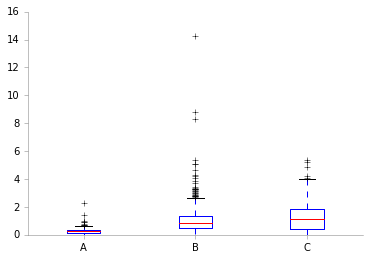

In [156]:
H_df.boxplot(grid=False)
format_axes(plt.gca())

In [169]:
def plot_appliance_factors(appliance):
    A_aggregate = pd.DataFrame(A_appl[appliance])
    return pd.Series(A_aggregate.T.values.reshape(6, ), index=range(1, 7))

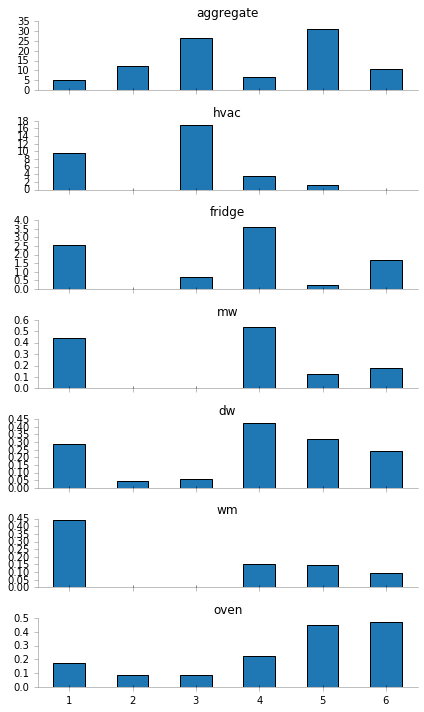

In [189]:
fig, ax = plt.subplots(nrows=7, sharex=True, figsize=(6, 10))
for i, appliance in enumerate(APPLIANCES_ORDER):
    plot_appliance_factors(appliance).plot(kind='bar',ax=ax[i], title=appliance, rot=0, color=tableau20blind[0])
    format_axes(ax[i])
plt.tight_layout()

In [167]:
A_aggregate.T.values.reshape(6, )

array([  9.59284856,   0.        ,  16.90117653,   3.50371053,
         1.19272504,   0.        ])

In [166]:
A_aggregate

,0,1
0,9.592849,3.503711
1,0.000000,1.192725
2,16.901177,0.000000


In [134]:
HA_agg = pd.DataFrame(np.dot(H_mean.reshape(-1,1).T, A_aggregate))
HA_agg.columns = ['X','Y']

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [138]:
HA_agg

,X,Y
0,1.604068,3.304767


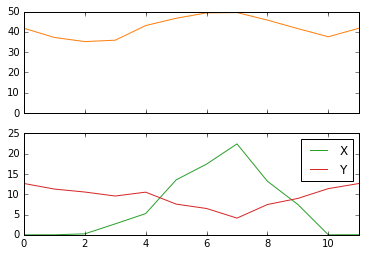

In [136]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, sharex=True)
pd.DataFrame(np.dot(HA_agg, T_fac.T)).squeeze().plot(ax=ax[0], color=tableau20blind[2])
(HA_agg['X']*T_fac['X']).plot(ax=ax[0])
T_fac.plot(ax=ax[1], colors=tableau20blind[4:][::2])

In [223]:
def get_XY(appliance):
    A_aggregate = pd.DataFrame(A_appl[appliance])
    HA_agg = pd.DataFrame(np.dot(H_mean.reshape(-1,1).T, A_aggregate))
    HA_agg.columns = ['X','Y']
    agg_df = pd.DataFrame({a:(HA_agg[a].values[0]*T_fac[a]) for a in ['X','Y']})
    sum_df = agg_df.sum()
    X_contri = (sum_df['X']*100/(sum_df.sum())).round()
    Y_contri = (sum_df['Y']*100/(sum_df.sum())).round()
    return agg_df, X_contri, Y_contri
    

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


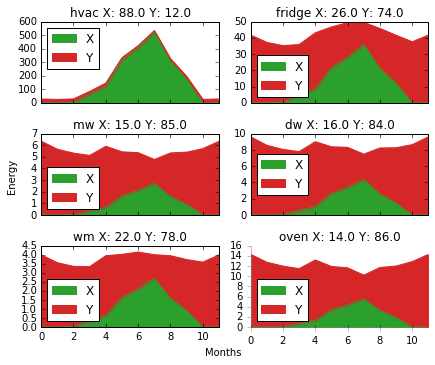

In [244]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(6, 5))
for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
    agg_df, X_contri, Y_contri = get_XY(appliance)
    agg_df.plot(kind='area', colors=tableau20blind[4:][::2], ax=ax[i/2, i%2])
    
    format_axes(plt.gca())
    
    ax[i/2, i%2].set_title("%s X: %0.1f Y: %0.1f" %(appliance, X_contri, Y_contri))
fig.tight_layout()
fig.text(0.5, 0.00, 'Months', ha='center')
fig.text(0, 0.5, 'Energy', va='center', rotation='vertical')
#


In [215]:
ax

In [201]:
pd.DataFrame(HAT[:,0,:])

,0,1,2,3,4,5,6,7,8,9,10,11
0,248.029105,219.993106,210.888109,238.376513,305.028499,412.593992,469.509488,524.025902,404.039569,320.639273,219.947042,244.671741
1,759.310769,673.481986,645.608152,729.760540,933.807442,1263.106043,1437.345874,1604.241207,1236.917725,981.597919,673.340967,749.032611
2,231.559586,205.385221,196.884810,222.547942,284.774132,385.197109,438.333328,489.229766,377.210713,299.348326,205.342216,228.425157
3,887.467620,787.152613,754.574219,852.929889,1091.415929,1476.293712,1679.941830,1875.005840,1445.685317,1147.272506,786.987792,875.454709
4,201.867431,179.049322,171.638892,194.011321,248.258443,335.804498,382.127227,426.497376,328.842172,260.963834,179.011831,199.134919
5,860.006725,762.795763,731.225442,826.537694,1057.644264,1430.612781,1627.959418,1816.987566,1400.951500,1111.772473,762.636042,848.365529
6,1060.031513,940.210726,901.297617,1018.778083,1303.636609,1763.352062,2006.598595,2239.591882,1726.792008,1370.354234,940.013857,1045.682748
7,647.719000,574.504006,550.726638,622.511607,796.570847,1077.474226,1226.106978,1368.474613,1055.134662,837.337818,574.383712,638.951367
8,263.766389,233.951524,224.268821,253.501346,324.382357,438.772810,499.299557,557.275001,429.675615,340.983625,233.902537,260.196002
9,467.531191,414.683747,397.520963,449.336198,574.974205,777.733567,885.018435,987.781068,761.608607,604.400284,414.596918,461.202610


In [193]:
pd.DataFrame(pred['hvac']).T.mean()

0      603.572540
1      535.349702
2      513.196733
3      580.096919
4      742.305174
5     1004.058529
6     1142.553774
7     1275.250204
8      983.246632
9      780.279086
10     535.237748
11     595.399563
dtype: float64

In [195]:
df[['aggregate_%d' %month for month in range(start, stop)]].mean()

aggregate_1      660.840981
aggregate_2      567.035560
aggregate_3      559.589831
aggregate_4      597.122320
aggregate_5      745.896280
aggregate_6     1020.126372
aggregate_7     1151.563518
aggregate_8     1281.998236
aggregate_9     1001.518678
aggregate_10     808.282627
aggregate_11     589.233787
aggregate_12     657.494219
dtype: float64

In [149]:
df[['aggregate_%d' %month for month in range(start, stop)]].head(2)

,aggregate_1,aggregate_2,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,aggregate_11,aggregate_12
22,378.088959,321.616699,255.916443,277.545471,308.597168,367.201874,398.430786,439.061493,328.362793,241.123642,265.382141,290.065521
26,765.002808,663.851074,769.035828,698.147339,995.478821,1299.501831,1035.324097,1708.114868,1231.774048,1073.366699,667.831177,800.943237


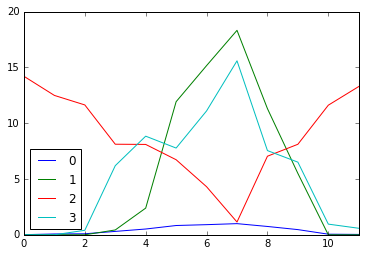

In [150]:
pd.DataFrame(T).plot()

In [78]:
HAT = multiply_case(H, A, T, case)

In [79]:
pd.DataFrame(HAT[i, :, :])

,0,1,2,3,4,5,6,7,8,9,10,11
0,433.782478,384.749795,368.825905,416.900857,533.469680,721.592853,821.133361,916.478071,706.631874,560.771636,384.669225,427.910616
1,114.097757,101.200696,97.012237,109.657386,140.318471,189.800488,215.982617,241.061125,185.865303,147.499701,101.179504,112.553282
2,18.993610,16.846664,16.149420,18.254431,23.358516,31.595682,35.954165,40.128930,30.940600,24.553960,16.843136,18.736504
3,2.448390,2.171636,2.081757,2.353105,3.011053,4.072873,4.634707,5.172859,3.988429,3.165152,2.171181,2.415248
4,4.053890,3.595658,3.446842,3.896124,4.985512,6.743607,7.673857,8.564896,6.603790,5.240661,3.594905,3.999015
5,1.708954,1.515782,1.453047,1.642446,2.101687,2.842828,3.234983,3.610609,2.783887,2.209248,1.515465,1.685821
6,5.905258,5.237756,5.020978,5.675442,7.262341,9.823338,11.178424,12.476390,9.619668,7.634013,5.236659,5.825322


In [80]:
pd.DataFrame(HAT.reshape(539, 84)).head()

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,248.029126,219.993107,210.888110,238.376514,305.028499,412.593993,469.509489,524.025903,404.039570,320.639274,...,2.870906,3.245117,4.152477,5.616810,6.391624,7.133779,5.500356,4.364993,2.994229,3.330816
1,759.310832,673.481991,645.608154,729.760542,933.807443,1263.106044,1437.345875,1604.241209,1236.917725,981.597919,...,8.788927,9.934528,12.712302,17.195178,19.567176,21.839191,16.838666,13.362893,9.166465,10.196885
2,231.559603,205.385220,196.884809,222.547940,284.774129,385.197105,438.333324,489.229762,377.210710,299.348324,...,2.680273,3.029636,3.876746,5.243845,5.967210,6.660084,5.135123,4.075151,2.795407,3.109644
3,887.467692,787.152616,754.574218,852.929889,1091.415927,1476.293709,1679.941826,1875.005836,1445.685313,1147.272503,...,10.272327,11.611283,14.857891,20.097389,22.869734,25.525220,19.680704,15.618289,10.713586,11.917920
4,201.867446,179.049322,171.638891,194.011320,248.258442,335.804496,382.127225,426.497374,328.842171,260.963833,...,2.336590,2.641155,3.379644,4.571444,5.202054,5.806083,4.476663,3.552607,2.436961,2.710904


In [81]:
pd.DataFrame(tensor[i, :, :])

,0,1,2,3,4,5,6,7,8,9,10,11
0,330.802338,285.298523,278.491577,366.379639,466.776825,764.197449,833.317505,1077.180420,756.499695,546.791443,323.729767,383.294556
1,0.000000,0.000000,0.521400,36.607632,115.083450,325.885712,398.898468,561.580811,324.993103,154.531708,0.552217,0.000000
2,37.878517,35.486267,43.560200,59.108418,65.193855,71.006134,65.868279,61.845417,62.528851,59.735748,44.482685,45.888268
3,8.005767,6.132550,4.687033,6.270417,6.698933,5.258967,3.980367,4.624333,5.781416,6.963400,9.656917,9.696151
4,15.436333,15.839884,12.617250,15.518066,16.831617,15.290983,10.394816,13.414667,15.315267,15.300016,18.818600,19.807501
5,2.600800,2.456467,1.445133,19.869850,1.723000,5.101800,1.001083,10.336000,2.167300,1.274367,2.083600,2.477900
6,0.071433,0.063567,0.048600,0.046600,0.053817,0.062550,0.045533,0.082117,0.065433,0.051417,0.061250,0.084017
